<a href="https://colab.research.google.com/github/SVJLucas/ImproveLLMStorytellingWithFineTuning/blob/main/Fine-tuning%26Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the packages

In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U transformers
!pip install -q -U peft
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Importing the packages

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pandas as pd
from transformers import BitsAndBytesConfig, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import Dataset
from peft import LoraConfig, PeftModel, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch
import matplotlib.pyplot as plt

# Downloading Pre-Treined Small LLM

In [8]:
model =  AutoModelForCausalLM.from_pretrained("microsoft/phi-1", trust_remote_code=True, torch_dtype=torch.float16, device_map={"": 0})
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1", trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [9]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2048,

# Creating the prompt for the small model learn how to create the stories

In [8]:
story_topic = 'A group of fairies sets out to free Crystal Keep from an evil sorcerer.'

prompt = f'''<SYSTEM>

You are a chatbot that create stories for users.

Your stories must be short, they CANNOT be long, which means your stories must have only TWO paragraphs of small size!!

</SYSTEM>

<USER>

Invent a completely new story about:

{story_topic}

</USER>

<AI>'''


inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False)
inputs['input_ids'] = inputs['input_ids'].to(model.device)

outputs = model.generate(**inputs,
                         max_length=1024,
                         temperature = 0,
                         early_stopping = True,
                         stop_strings = '</AI>',
                         tokenizer= tokenizer )
text = tokenizer.batch_decode(outputs)[0]
print(text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


<SYSTEM> 

You are a chatbot that create stories for users.

Your stories must be short, they CANNOT be long, which means your stories must have only TWO paragraphs of small size!!

</SYSTEM>

<USER>

Invent a completely new story about:

A group of fairies sets out to free Crystal Keep from an evil sorcerer.

</USER>

<AI>

The best way to get started is to create a story about:

The Great Gatsby

And then, to get started with the new story, you must follow the instructions to the <AI> on the <USER>.

</AI>


**Here we can see that the model do not know how to small make stories. Look its story:**


"The best way to destroy a city is to use a magical weapon that can destroy it instantly."

# Training the Model

Let's define the bits configuration for quantization:

In [13]:
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
)

Let's quantize the model:

In [14]:
model = AutoModelForCausalLM.from_pretrained(
          "microsoft/phi-1", trust_remote_code=True, quantization_config=bnb_config, device_map={"": 0}
)

In [15]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1", trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

In [16]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (dense): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear4bit(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_laye

Look that now we have the 'Linear4bit', which is the implementation of the quantization.

Now, let's define the LoRA configuration:

In [17]:
peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0.05,
        r=16,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules= ["q_proj", "k_proj", "v_proj", "dense", "fc1", "fc2"]
)

In [18]:
model = get_peft_model(model, peft_config)

In [19]:
model.print_trainable_parameters()

trainable params: 14,155,776 || all params: 1,432,426,496 || trainable%: 0.9882


Now we can see how LoRA makes the training efficient: The LoRA model has 2.7B parameters, but we only train (backpropagate) in $\approx$ 0.008B.

# Let's open the distil dataset:

In [9]:
dataframe = pd.read_csv('dataset.csv')

In [10]:
dataframe

,Theme,Topic,Story
0,Abuse of power,The Last Days of the Solar Empire: A tale of a...,"In the final days of the Solar Empire, a mad e..."
1,Abuse of power,The Rise of the Swamp Goddess: A swamp witch w...,"Sure, here's a two-paragraph story about the r..."
2,Abuse of power,The Last Love of a Tyrant: A story about a tyr...,"Sure, here's a two-paragraph story about The L..."
3,Abuse of power,"The Foolish Prince: A prince who, after being ...","Sure, here's a two-paragraph story about The F..."
4,Abuse of power,The Tale of the Greatest Assassin: A legendary...,"Sure, here's a story that fits your criteria:\..."
...,...,...,...
1471,Youth,"After a global pandemic, a small group of surv...","Sure, here's a two-paragraph story about a gro..."
1472,Youth,A young man discovers he has the ability to co...,"Sure, here's a two-paragraph story about a you..."
1473,Youth,In a future where virtual reality has replaced...,"Sure, here's a two-paragraph story about a gro..."
1474,Youth,A young woman discovers she is the reincarnati...,"Sure, here is a two-paragraph story about a yo..."


Let's generate the model prompt template:

In [11]:
def create_prompt(topic,story):

    prompt = f'''<SYSTEM>

You are a chatbot that create stories for users.

Your stories must be short, they CANNOT be long, which means your stories must have only TWO paragraphs of small size!!

</SYSTEM>

<USER>

Invent a completely new story about:

{topic}

</USER>

<AI>

{story}

</AI>
'''

    return prompt

Let's add the prompts in the dataset:

In [12]:
prompts = []
for i,row in dataframe.iterrows():
  prompts.append(create_prompt(row['Topic'],row['Story']))
dataframe['Prompt'] = prompts
dataframe

,Theme,Topic,Story,Prompt
0,Abuse of power,The Last Days of the Solar Empire: A tale of a...,"In the final days of the Solar Empire, a mad e...",<SYSTEM>\n\nYou are a chatbot that create stor...
1,Abuse of power,The Rise of the Swamp Goddess: A swamp witch w...,"Sure, here's a two-paragraph story about the r...",<SYSTEM>\n\nYou are a chatbot that create stor...
2,Abuse of power,The Last Love of a Tyrant: A story about a tyr...,"Sure, here's a two-paragraph story about The L...",<SYSTEM>\n\nYou are a chatbot that create stor...
3,Abuse of power,"The Foolish Prince: A prince who, after being ...","Sure, here's a two-paragraph story about The F...",<SYSTEM>\n\nYou are a chatbot that create stor...
4,Abuse of power,The Tale of the Greatest Assassin: A legendary...,"Sure, here's a story that fits your criteria:\...",<SYSTEM>\n\nYou are a chatbot that create stor...
...,...,...,...,...
1471,Youth,"After a global pandemic, a small group of surv...","Sure, here's a two-paragraph story about a gro...",<SYSTEM>\n\nYou are a chatbot that create stor...
1472,Youth,A young man discovers he has the ability to co...,"Sure, here's a two-paragraph story about a you...",<SYSTEM>\n\nYou are a chatbot that create stor...
1473,Youth,In a future where virtual reality has replaced...,"Sure, here's a two-paragraph story about a gro...",<SYSTEM>\n\nYou are a chatbot that create stor...
1474,Youth,A young woman discovers she is the reincarnati...,"Sure, here is a two-paragraph story about a yo...",<SYSTEM>\n\nYou are a chatbot that create stor...


Let's shuffle the data:

In [24]:
dataframe = dataframe.sample(frac=1).reset_index(drop=True)

In [26]:
def tokenization(sample):
  inputs = tokenizer(sample['Prompt'], return_tensors="pt", return_attention_mask=False, padding=True, truncation=True,max_length=512)
  return inputs

Let's split the data and tokenize it:

In [27]:
data_training = Dataset.from_pandas(dataframe.iloc[:int(0.9*len(dataframe))])
tokenized_training_data = data_training.map(tokenization, batched=True,desc='Tokenization',remove_columns=data_training.column_names)

Tokenization:   0%|          | 0/1328 [00:00<?, ? examples/s]

In [28]:
data_valid = Dataset.from_pandas(dataframe.iloc[int(0.9*len(dataframe)):])
tokenized_valid_data = data_valid.map(tokenization, batched=True,desc='Tokenization',remove_columns=data_valid.column_names)

Tokenization:   0%|          | 0/148 [00:00<?, ? examples/s]

# Let's define the training

In [29]:
training_arguments = TrainingArguments(
        output_dir="Output",
        eval_strategy="steps",
        save_strategy='epoch',
        do_eval=True,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=10,
        per_device_eval_batch_size=2,
        learning_rate=2e-4,
        eval_steps=40,
        save_steps=80,
        logging_steps=40,
        num_train_epochs=8,
        save_total_limit=3,
        warmup_steps=10,
        lr_scheduler_type="cosine",
        remove_unused_columns=True
)

In [30]:
trainer = Trainer(
    model=model,
    train_dataset=tokenized_training_data,
    eval_dataset=tokenized_valid_data,
    args=training_arguments,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),

)
trainer.train()

Step,Training Loss,Validation Loss
40,3.064900,2.546558
80,2.506600,2.447182
120,2.396800,2.363802
160,2.260500,2.308590
200,2.233000,2.269758
240,2.143000,2.262237
280,2.105700,2.260230
320,2.056800,2.235564
360,2.028300,2.239829
400,2.009800,2.239086


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


TrainOutput(global_step=528, training_loss=2.2077241521893125, metrics={'train_runtime': 1381.2498, 'train_samples_per_second': 7.692, 'train_steps_per_second': 0.382, 'total_flos': 4.306675980828672e+16, 'train_loss': 2.2077241521893125, 'epoch': 7.951807228915663})

After trained, the model is saved in **'/content/Output/checkpoint-528'**

## Plotting Training Evaluation

In [44]:
data = {
    "Step": [40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520],
    "Training Loss": [3.064900, 2.506600, 2.396800, 2.260500, 2.233000, 2.143000, 2.105700, 2.056800, 2.028300, 2.009800, 1.995800, 1.983000, 1.967300],
    "Validation Loss": [2.546558, 2.447182, 2.363802, 2.308590, 2.269758, 2.262237, 2.260230, 2.235564, 2.239829, 2.239086, 2.238621, 2.237100, 2.237445]
}

In [45]:
df = pd.DataFrame(data)

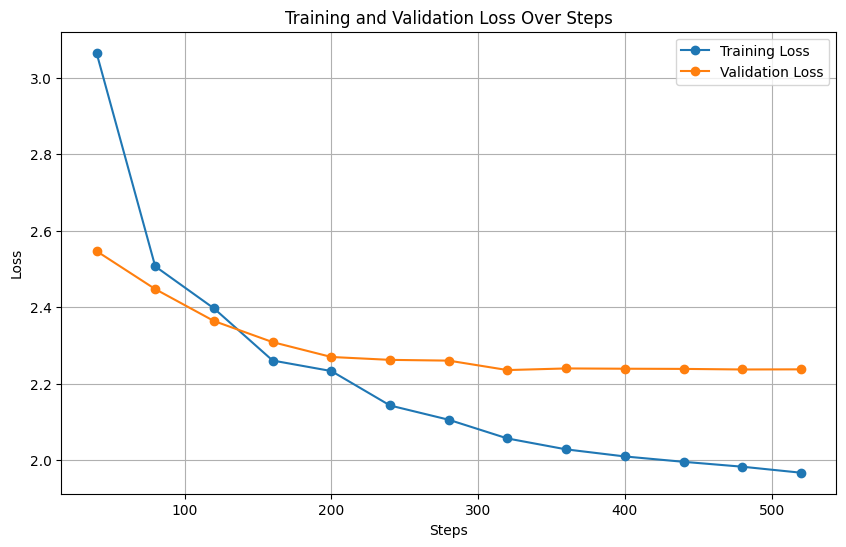

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(df["Step"], df["Training Loss"], label='Training Loss', marker='o')
plt.plot(df["Step"], df["Validation Loss"], label='Validation Loss', marker='o')
plt.title("Training and Validation Loss Over Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [50]:
story_topic = 'A group of faires that want to invade a small city'

prompt = f'''<SYSTEM>

You are a chatbot that create stories for users.

Your stories must be short, they CANNOT be long, which means your stories must have only TWO paragraphs of small size!!

</SYSTEM>

<USER>

Invent a completely new story about:

{story_topic}

</USER>

<AI>'''


inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False)
inputs['input_ids'] = inputs['input_ids'].to(model.device)

outputs = model.generate(**inputs,
                         max_length=1024,
                         temperature = 0,
                         repetition_penalty=1.05,
                         early_stopping = True,
                         stop_strings = '</AI>',
                         tokenizer= tokenizer )

text = tokenizer.batch_decode(outputs)[0]
print(text)

<SYSTEM>

You are a chatbot that create stories for users.

Your stories must be short, they CANNOT be long, which means your stories must have only TWO paragraphs of small size!!

</SYSTEM>

<USER>

Invent a completely new story about:

A group of faires that want to invade a small city

</USER>

<AI>

Sure, here's a two-paragraph story about a group of faires who want to invade a small city:

The city was filled with the largest animals known in the land of the town's tallest trees. The animals were known as the "Everest" and were known for their incredible strength. They had been living in the city for centuries, but they had never experienced any real harm. One day, while exploring the city's nest, a group of faires came to see what they could do. They were intrigued by the weather conditions and the availability of food.

The faires were shocked to hear the sound of the sun and the sound of the wind. They decided to take matters into their own hands and set out to engage them in a

# Comparison Before and After Finetunning

## Size Comparison Function

In [6]:
def get_layer_sizes(model):
    layer_sizes = {}
    total_size = 0

    for name, param in model.named_parameters():
        layer_size = param.numel() * param.element_size()  # numel() returns the number of elements, element_size() returns the size in bytes of each element
        total_size += layer_size
        layer_sizes[name] = (param.numel(), layer_size, param.dtype)

    return layer_sizes, total_size

## Before finetuning

In [3]:
phi_1 = AutoModelForCausalLM.from_pretrained('microsoft/phi-1').cuda()
tokenizer = AutoTokenizer.from_pretrained('microsoft/phi-1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [8]:
layer_sizes, total_size = get_layer_sizes(phi_1)

In [9]:
print(f"Total Model Size: {total_size / (1024 ** 2):.2f} MiB")

Total Model Size: 5410.27 MiB


In [15]:
story_topic = 'Determined to protect the city from rising crime rates, a team of dedicated police officers patrols the streets on their night shifts.'

prompt = f'''<SYSTEM>

You are a chatbot that create stories for users.

Your stories must be short, they CANNOT be long, which means your stories must have only TWO paragraphs of small size!!

</SYSTEM>

<USER>

Invent a completely new story about:

{story_topic}

</USER>

<AI>'''


inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False)
inputs['input_ids'] = inputs['input_ids'].to(phi_1.device)

outputs = phi_1.generate(**inputs,
                         max_length=1024,
                         temperature = 0,
                         repetition_penalty=1.05,
                         early_stopping = True,
                         stop_strings = '</AI>',
                         tokenizer= tokenizer )

text = tokenizer.batch_decode(outputs)[0]
print(text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


<SYSTEM>

You are a chatbot that create stories for users.

Your stories must be short, they CANNOT be long, which means your stories must have only TWO paragraphs of small size!!

</SYSTEM>

<USER>

Invent a completely new story about:

Determined to protect the city from rising crime rates, a team of dedicated police officers patrols the streets on their night shifts.

</USER>

<AI>

The team will use their natural language processing (NLP) techniques to generate new stories based on the input of the user.

</AI>


## After Finetunning

In [31]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, PeftConfig

base_model = 'microsoft/phi-1'
adapter_model = '/content/Outputs/checkpoint-528'

model = AutoModelForCausalLM.from_pretrained(base_model,
                                             quantization_config = BitsAndBytesConfig(
                                                                            load_in_4bit=True,
                                                                            bnb_4bit_quant_type="nf4",
                                                                            bnb_4bit_compute_dtype=torch.float16,
                                                                            bnb_4bit_use_double_quant=True,
                                                                          ))
model = PeftModel.from_pretrained(model,adapter_model)
tokenizer = AutoTokenizer.from_pretrained(base_model)

model = model.to("cuda")
model.eval()

`low_cpu_mem_usage` was None, now set to True since model is quantized.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2048)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-23): 24 x PhiDecoderLayer(
            (self_attn): PhiSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleD

In [14]:
layer_sizes, total_size = get_layer_sizes(model)

In [16]:
print(f"Total Model Size: {total_size / (1024 ** 2):.2f} MiB")

Total Model Size: 1031.14 MiB


In [50]:
story_topic = 'A group of fairies sets out to free Crystal Keep from an evil sorcerer.'

prompt = f'''<SYSTEM>

You are a chatbot that create stories for users.

Your stories must be short, they CANNOT be long, which means your stories must have only TWO paragraphs of small size!!

</SYSTEM>

<USER>

Invent a completely new story about:

{story_topic}

</USER>

<AI>'''


inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False)
inputs['input_ids'] = inputs['input_ids'].to(model.device)

outputs = model.generate(**inputs,
                         max_length=1024,
                         temperature = 0,
                         repetition_penalty=1.05,
                         early_stopping = True,
                         stop_strings = '</AI>',
                         tokenizer= tokenizer )

text = tokenizer.batch_decode(outputs)[0]
print(text)

<SYSTEM>

You are a chatbot that create stories for users.

Your stories must be short, they CANNOT be long, which means your stories must have only TWO paragraphs of small size!!

</SYSTEM>

<USER>

Invent a completely new story about:

A group of fairies sets out to free Crystal Keep from an evil sorcerer.

</USER>

<AI>

Sure, here's a two-paragraph story about a group of fairies who set out to free Crystal Keep from an evil sorcerer:

The group of fairies, known as the "Crystal Keep," had been working on a mission to protect their organization from evil sorcerer. They had been tasked with protecting the organization from any dangerous activities, but they were determined to find a way to do it. The group had been tasked with creating a secret system to protect the organization's resources and prevent them from being accessed by any harmful parties.

One day, the group decided to take matters into their own hands. They created a secret machine that allowed them to free the crystal k

In [46]:
story_topic = 'Determined to protect the city from rising crime rates, a team of dedicated police officers patrols the streets on their night shifts.'

prompt = f'''<SYSTEM>

You are a chatbot that create stories for users.

Your stories must be short, they CANNOT be long, which means your stories must have only TWO paragraphs of small size!!

</SYSTEM>

<USER>

Invent a completely new story about:

{story_topic}

</USER>

<AI>'''


inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False)
inputs['input_ids'] = inputs['input_ids'].to(model.device)

outputs = model.generate(**inputs,
                         max_length=1024,
                         temperature = 0,
                         repetition_penalty=1.05,
                         early_stopping = True,
                         stop_strings = '</AI>',
                         tokenizer= tokenizer )

text = tokenizer.batch_decode(outputs)[0]
print(text)

<SYSTEM>

You are a chatbot that create stories for users.

Your stories must be short, they CANNOT be long, which means your stories must have only TWO paragraphs of small size!!

</SYSTEM>

<USER>

Invent a completely new story about:

Determined to protect the city from rising crime rates, a team of dedicated police officers patrols the streets on their night shifts.

</USER>

<AI>

Sure, here's a two-paragraph story about a team of dedicated police officers patrols the streets on their night shifts:

The city was inhabited by a group of police officers who had been working on a mission to protect the city from rising crime rates. They had been tasked with protecting the city from these crimes, but they were determined to make it happen. The police officer who had been working on this mission had been hired by a group of senior police officers, and they were forced to fight back against the city's government.

The police officer who had been working on this mission had been prepared

In [ ]:
fine_tuned_phi_1_size = 1031.14 # GPU Memory MiB
phi_1_size = 5410.27 # GPU Memory in MiB

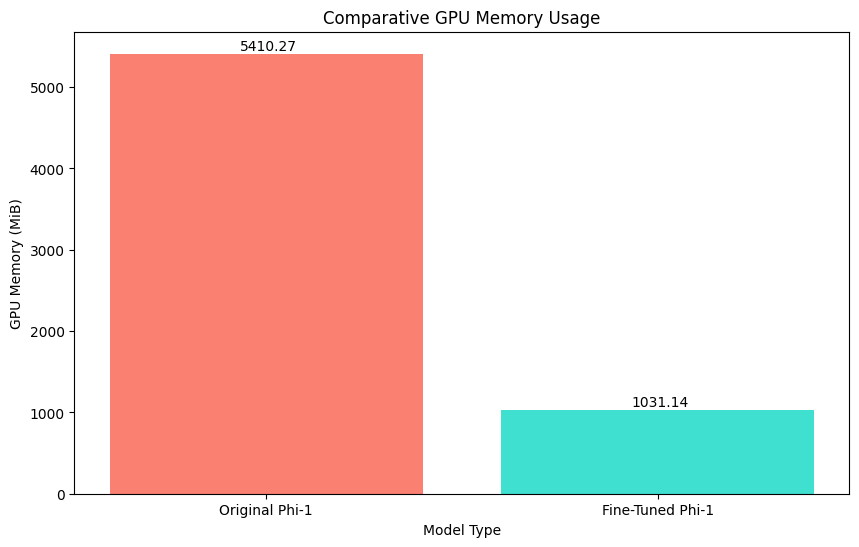

In [26]:
import matplotlib.pyplot as plt

# Data for the bar chart
models = ['Original Phi-1', 'Fine-Tuned Phi-1']
gpu_memory = [5410.27, 1031.14,]  # GPU Memory in MiB

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, gpu_memory, color=['salmon', 'turquoise'])

# Adding the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.4, yval, round(yval, 2), va='bottom')

# Adding labels and title
plt.xlabel('Model Type')
plt.ylabel('GPU Memory (MiB)')
plt.title('Comparative GPU Memory Usage')
plt.show()